In [1]:
import pandas as pd
import yfinance as yf
import datetime as dt
import numpy as np
import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as sc
import pandas_datareader.data as pdr
import matplotlib.dates as mdates

In [5]:
def fib(n):
    p, q = 0, 1
    count = 0
    while (count < n):
        yield p
        p, q = q, p+q

t = fib(10)
for i in t

0
1
1
2
3
5
8
13
21
34


## Read ESG Data and Create Portfolios

In [156]:
esg_data= pd.read_csv("H:/My Drive/Projects/ESG_Momentum_Strategy/Data/ESG_Data_Yearly.csv")
# esg_data.sort_values(by=['ESG Disc Score','Mkt Cap'],ascending=False,inplace=True)
stks_to_remove = ['JCS', 'VYEY','SEII','CSLT']
for i in stks_to_remove:
    esg_data.replace(i+" US Equity",np.nan,inplace=True)
esg_data.dropna(axis=0,inplace=True)
year_group=esg_data.groupby(by='YEAR')

In [157]:
#Portfolio Creation using ESG
port_size = 50
port_stks_high_esg = pd.DataFrame()
port_stks_low_esg = pd.DataFrame()
for i in range(2010,2021):
    temp = year_group.get_group(i)
    temp.sort_values(by='ESG_DISC_SCORE',ascending=True,inplace=True)
    temp_len = len(temp)
    port_stks_high_esg[i] = [s for s in temp['ID'][temp_len-port_size:]]
    port_stks_low_esg[i] = [s for s in temp['ID'][:port_size]]



In [158]:
# stocks we need the data for from the master STOCK_PRICE file. 
stks_needed_1 = [item for t in port_stks_high_esg.values.tolist() for item in t]
stks_needed_2 = [item for t in port_stks_low_esg.values.tolist() for item in t]
stks_needed = set(stks_needed_1).union(set(stks_needed_2))
stks_needed = list(stks_needed)
stks_needed = [i.replace(" US Equity","") for i in stks_needed]
# stks_needed
# pd.DataFrame(list(stks_needed)).to_csv("Stocks_needed.csv")

## Create Stock Price Data (Not needed to run each time)

In [121]:
# ##Remove tickers for which there is no data avaialble 
# stks_remove = ['JCS', 'VYEY']

# for i in stks_remove:
#     temp_i = i+" US Equity"
#     # print(temp_i)
#     # stks_needed.remove(i)
#     port_stks_high_esg.replace(temp_i,np.nan)
#     port_stks_high_esg.fillna(method='ffill',inplace=True)
#     port_stks_low_esg.replace(temp_i,np.nan)
#     port_stks_low_esg.fillna(method='ffill',inplace=True)

In [165]:

#Create the stock price database 
st_date = dt.datetime(2010,1,1)
en_date = dt.datetime(2020,12,31)
Stk_prices_list = []
flag = 0
tc_list = []
for tc in list(stks_needed):
    if flag ==0 : 
        flag =1 
        Stk_prices_list.append(pdr.DataReader(tc, 'yahoo', start=st_date, end=en_date)['Adj Close'].index)
        tc_list.append('Date')
    try:
        Stk_prices_list.append(pdr.DataReader(tc, 'yahoo', start=st_date, end=en_date)['Adj Close'].tolist())
        tc_list.append(tc)
    except:
        print(tc)
    

Stk_prices_list=list(map(list, itertools.zip_longest(*Stk_prices_list, fillvalue=None)))
Stock_prices = pd.DataFrame(Stk_prices_list,columns=tc_list)
# Stock_prices.set_index('Date',inplace=True)

#Create Database of stock prices
Stock_prices.to_csv("STOCK_PRICE_CLOSE.csv")        

ACY
INTEQ
SHMP
AFHIF
SQBGQ
REPH
TUEM
LBTI
GTHP
FLDM
SDRLF


## Read Stock Prices from file

In [166]:
#read from Stock prices database
Stock_prices = pd.read_csv("H:/My Drive/Projects/ESG_Momentum_Strategy/STOCK_PRICE_CLOSE.csv",index_col='Date')
# Stock_prices.drop('Unnamed: 0',axis= 1,inplace=True)
Stock_prices.fillna(method='ffill',inplace=True)
Stock_prices.index = pd.to_datetime(Stock_prices.index)
Stock_returns = Stock_prices.pct_change()


## Create Momentum Portfolios

In [ ]:
Mom_HESG_Buy_portfolio = []
Mom_HESG_Sell_portfolio = []
Mom_LESG_Buy_portfolio = []
Mom_LESG_Sell_portfolio = []

Mom_Port_length = 10

#Create Date Ranges of observation periods 
# Assume first observation period starts from 04-01-2010
Observation_start_date = dt.datetime(2010,4,1)
Obs_per_st_dates = [Observation_start_date + pd.DateOffset(months=3*i) for i in range(45)]
Dates = Stock_returns.index
Obs_per_date_ranges = []

Dates = Dates[Dates>=Observation_start_date]
for per_st in Obs_per_st_dates[1:]:
    Obs_per_date_ranges.append(Dates[Dates<=per_st].tolist())
    Dates = Dates[Dates>per_st]
Obs_per_date_ranges.pop()


toggle = 0
for port in [port_stks_high_esg,port_stks_low_esg]:
    for rng in Obs_per_date_ranges:
        # print(len(rng))
        year = rng[0].year
        if rng[0].month<3 and year > 2010:
            year = year -1 
        tc_dict={}
        for tc in port[year]:
            c = tc.replace(' US Equity','')
            try:
                ret = Stock_returns[c][rng]
            except:
                ret = [0]*len(rng)
            ret = [1+i for i in ret]
            tc_dict[c] = np.prod(ret)
        #get the 10 highest/lowest return tciekrs and add to buy/sell portfolio    
        temp_list = sorted(tc_dict , key = tc_dict.get,reverse=True)
        if toggle == 0:
            Mom_HESG_Buy_portfolio.append(temp_list[:Mom_Port_length])
            Mom_HESG_Sell_portfolio.append(temp_list[-Mom_Port_length:])
        else:
            Mom_LESG_Buy_portfolio.append(temp_list[:Mom_Port_length])
            Mom_LESG_Sell_portfolio.append(temp_list[-Mom_Port_length:])
    toggle = 1


In [190]:
#Calculate daily returns for the momentum strategy portfolios 

Scalar = 1/(2*Mom_Port_length)
Mom_HESG_Returns = []
Mom_LESG_Returns = []
Dates_index  = [i for j in Obs_per_date_ranges[1:] for i in j]


#HIGH ESG PORTFOLIO
for i in range(1,len(Obs_per_date_ranges)):
    temp = [0]*len(Obs_per_date_ranges[i])
    for tc in range(Mom_Port_length):
        for k in range(len(Obs_per_date_ranges[i])):
            # print(Stock_returns[Mom_HESG_Buy_portfolio[i][tc]][Obs_per_date_ranges[i][k]], i, k , tc)
            try:
                temp_high_rets= Stock_returns[Mom_HESG_Buy_portfolio[i-1][tc]][Obs_per_date_ranges[i][k]]
            except:
                temp_high_rets=0
            try:
                temp_low_rets= Stock_returns[Mom_HESG_Sell_portfolio[i-1][tc]][Obs_per_date_ranges[i][k]]
            except:
                temp_low_rets =0
            temp[k] = temp[k] + ((temp_low_rets-temp_high_rets)*Scalar)
    Mom_HESG_Returns.append(temp)
Mom_HESG_Returns = [Mom_HESG_Returns[i][j] for i in range(len(Mom_HESG_Returns)) for j in range(len(Mom_HESG_Returns[i]))]


#LoW ESG PORTFOLIO
for i in range(1,len(Obs_per_date_ranges)):
    temp = [0]*len(Obs_per_date_ranges[i])
    for tc in range(Mom_Port_length):
        for k in range(len(Obs_per_date_ranges[i])):
            # print(Stock_returns[Mom_HESG_Buy_portfolio[i][tc]][Obs_per_date_ranges[i][k]], i, k , tc)
            try:
                temp_high_rets= Stock_returns[Mom_LESG_Buy_portfolio[i-1][tc]][Obs_per_date_ranges[i][k]]
            except:
                temp_high_rets = 0
            try:
                temp_low_rets= Stock_returns[Mom_LESG_Sell_portfolio[i-1][tc]][Obs_per_date_ranges[i][k]]
            except:
                temp_low_rets=0
            temp[k] = temp[k] + ((temp_low_rets-temp_high_rets)*Scalar)
    Mom_LESG_Returns.append(temp)
Mom_LESG_Returns = [Mom_LESG_Returns[i][j] for i in range(len(Mom_LESG_Returns)) for j in range(len(Mom_LESG_Returns[i]))]

Mom_Returns = pd.DataFrame(list(zip(Mom_HESG_Returns,Mom_LESG_Returns)),columns=['HIGHESG','LOWESG'],index=Dates_index)
# Mom_Returns.to_csv("Momentum_Returns.csv")

In [193]:
Mom_Returns.to_csv('Momentum_Returns.csv')

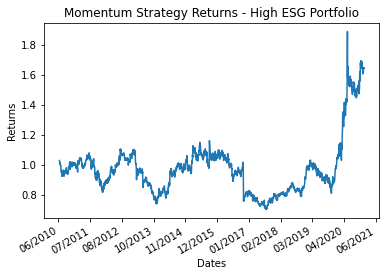

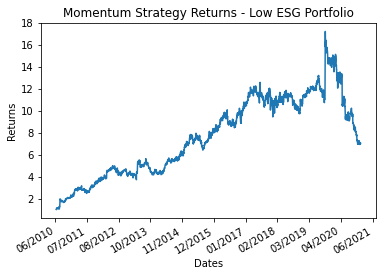

In [237]:
t = [1+i for i in Mom_HESG_Returns]
t = np.cumprod(t)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=400))
plt.plot(Dates_index,t)
plt.gcf().autofmt_xdate()
plt.xlabel("Dates")
plt.ylabel("Returns")
plt.title("Momentum Strategy Returns - High ESG Portfolio")
plt.show()

s = [1+i for i in Mom_LESG_Returns]
s = np.cumprod(s)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=400))
plt.plot(Dates_index,s)
plt.gcf().autofmt_xdate()
plt.xlabel("Dates")
plt.ylabel("Returns")
plt.title("Momentum Strategy Returns - Low ESG Portfolio")
plt.show()

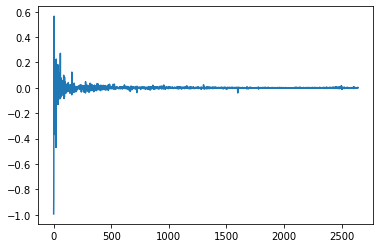

In [252]:
t = [((1+Mom_HESG_Returns[i])**(365/max(1,i))-1) for i in range(len(Mom_HESG_Returns))]
plt.plot(t[1:])
plt.show()

[0, 0]

## FAMA FRENCH FITTING

In [212]:
#Read FF factors 
ff_factors = pd.read_csv("H:/My Drive/Projects/ESG_Momentum_Strategy/Data/Fama_French_Factors.csv",index_col="date",parse_dates=['date'])
ff_factors.head()

#Create a dataframe of fama frenchfactors and our returns 
mkt_rf = []
smb = []
hml = []
rf = []
for i in Mom_Returns.index:
    mkt_rf.append(ff_factors['Mkt-RF'][i])
    smb.append(ff_factors['SMB'][i])
    hml.append(ff_factors['HML'][i])
    rf.append(ff_factors['RF'][i])

fama_french_factors = pd.DataFrame(list(zip(mkt_rf,smb,hml)),columns=['MKT-RF',"SMB","HML"],index=Mom_Returns.index)
 

In [216]:
#High ESG portfolio
X = sm.add_constant(fama_french_factors[['MKT-RF',"SMB","HML"]])
Y = [Mom_Returns['HIGHESG'][i]-rf[i] for i in range(len(Mom_Returns['HIGHESG']))]
model1 = sm.OLS(Y,X).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     24.07
Date:                Wed, 13 Apr 2022   Prob (F-statistic):           2.32e-15
Time:                        16:15:23   Log-Likelihood:                 6402.1
No. Observations:                2644   AIC:                        -1.280e+04
Df Residuals:                    2640   BIC:                        -1.277e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0122      0.000    -29.004      0.000      -0.013      -0.011
MKT-RF         0.0005      0.000      1.271      0.204      -0.000       0.001
SMB            0.0020      0.001      2.607      0.009       0.000       0.003
HML            0.0045      0.001      7.382      0.000       0.003       0.006
==============================================================================
Omnibus:                      304.601   Durbin-Watson:                   0.664
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              559.328
Skew:                          -0.755   Prob(JB):                    3.50e-122
Kurtosis:                       4.673   Cond. No.                         2.10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [217]:
#Low ESG portfolio
X = sm.add_constant(fama_french_factors[['MKT-RF',"SMB","HML"]])
Y = [Mom_Returns['LOWESG'][i]-rf[i] for i in range(len(Mom_Returns['LOWESG']))]
model1 = sm.OLS(Y,X).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.637
Date:                Wed, 13 Apr 2022   Prob (F-statistic):             0.0481
Time:                        16:15:37   Log-Likelihood:                 5992.0
No. Observations:                2644   AIC:                        -1.198e+04
Df Residuals:                    2640   BIC:                        -1.195e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0074      0.000    -15.021      0.000      -0.008      -0.006
MKT-RF         0.0007      0.000      1.562      0.119      -0.000       0.002
SMB            0.0005      0.001      0.580      0.562      -0.001       0.002
HML            0.0013      0.001      1.807      0.071      -0.000       0.003
==============================================================================
Omnibus:                     1610.540   Durbin-Watson:                   1.605
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            91380.730
Skew:                           2.158   Prob(JB):                         0.00
Kurtosis:                      31.475   Cond. No.                         2.10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## STATIC PORTFOLIO STRATEGY

## Calculate Portfolio Returns 

In [205]:
#ESG portfolios - Static
#Calculate the daily returns for ESG portfolios 
Dates = Stock_returns.index
Dates_len = len(Dates)
port_ret_high = []
port_ret_low = []

#initialize dataframe of len dates
# Loop over different portfolios and calcualte the daily returns for them 
toggle = 0
for port in [port_stks_high_esg,port_stks_low_esg]:
    for i in Dates[1:]:
        #debug conditoin
        if i.year == 2021:
            break
        temp = 0.0

        for j in port[i.year]:
            try:
                temp = temp + Stock_returns[j.replace(' US Equity','')][i] * 0.02
            except:
                temp = temp
        if toggle == 0:
            port_ret_high.append(temp)
        else:
            port_ret_low.append(temp)
    toggle = 1
port_ret_high_esg = pd.DataFrame(port_ret_high,index=Dates[1:],columns=['Returns'])
port_ret_low_esg = pd.DataFrame(port_ret_low,index=Dates[1:],columns=['Returns'])


port_ret_high_esg.to_csv("Port_high_ret_daily.csv")
port_ret_low_esg.to_csv("Port_low_ret_daily.csv")


## Fama French Model Fitting

In [221]:
#Read FF factors 
ff_factors = pd.read_csv("H:/My Drive/Projects/ESG_Momentum_Strategy/Data/Fama_French_Factors.csv",index_col="date",parse_dates=['date'])
ff_factors.head()

#Create a dataframe of fama frenchfactors and our returns 
mkt_rf = []
smb = []
hml = []
rf = []
for i in port_ret_high_esg.index:
    mkt_rf.append(ff_factors['Mkt-RF'][i])
    smb.append(ff_factors['SMB'][i])
    hml.append(ff_factors['HML'][i])
    rf.append(ff_factors['RF'][i])

fama_french_factors = pd.DataFrame(list(zip(mkt_rf,smb,hml)),columns=['MKT-RF',"SMB","HML"],index=port_ret_high_esg.index)



In [222]:
#High ESG portfolio

X = sm.add_constant(fama_french_factors[['MKT-RF',"SMB","HML"]])
Y = [port_ret_high_esg['Returns'][i] - rf[i] for i in range(len(port_ret_high_esg['Returns']))]
model1 = sm.OLS(Y,X).fit()
model1.summary()


2768


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     1673.
Date:                Wed, 13 Apr 2022   Prob (F-statistic):               0.00
Time:                        16:17:35   Log-Likelihood:                 9731.8
No. Observations:                2768   AIC:                        -1.946e+04
Df Residuals:                    2764   BIC:                        -1.943e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0020      0.000    -14.392      0.000      -0.002      -0.002
MKT-RF         0.0064      0.000     50.391      0.000       0.006       0.007
SMB            0.0064      0.000     25.418      0.000       0.006       0.007
HML            0.0039      0.000     19.092      0.000       0.003       0.004
==============================================================================
Omnibus:                      821.873   Durbin-Watson:                   1.554
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10681.859
Skew:                           1.033   Prob(JB):                         0.00
Kurtosis:                      12.399   Cond. No.                         2.13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [224]:
#Low ESG portfolio
Y = [port_ret_low_esg['Returns'][i] - rf[i] for i in range(len(port_ret_low_esg['Returns']))]
model2 = sm.OLS(Y,X).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     28.27
Date:                Wed, 13 Apr 2022   Prob (F-statistic):           5.28e-18
Time:                        16:18:24   Log-Likelihood:                 5420.8
No. Observations:                2768   AIC:                        -1.083e+04
Df Residuals:                    2764   BIC:                        -1.081e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.001     -0.271      0.786      -0.001       0.001
MKT-RF         0.0047      0.001      7.719      0.000       0.003       0.006
SMB            0.0029      0.001      2.444      0.015       0.001       0.005
HML            0.0006      0.001      0.626      0.531      -0.001       0.002
==============================================================================
Omnibus:                     8400.639   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        543424573.676
Skew:                          43.927   Prob(JB):                         0.00
Kurtosis:                    2171.883   Cond. No.                         2.13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

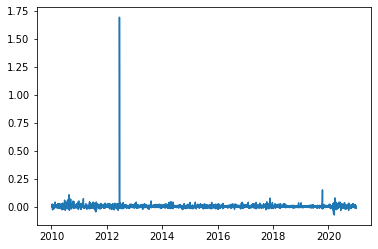

             Returns  Cum_Rets
Date                          
2010-01-05  0.010504  1.010504
2010-01-06  0.016598  1.016598
2010-01-07  0.002472  1.002472
2010-01-08 -0.006023  0.993977
2010-01-11  0.022736  1.022736
...              ...       ...
2020-12-24 -0.001121  0.998879
2020-12-28 -0.002056  0.997944
2020-12-29 -0.017471  0.982529
2020-12-30 -0.004090  0.995910
2020-12-31  0.000062  1.000062

[2768 rows x 2 columns]


In [225]:
port_ret_high_esg["Cum_Rets"] = port_ret_high_esg["Returns"]+1
port_ret_low_esg["Cum_Rets"] = port_ret_low_esg["Returns"]+1
cum_rets_high_esg = port_ret_high_esg["Cum_Rets"].cumprod()
cum_rets_low_esg = port_ret_low_esg["Cum_Rets"].cumprod()

# plt.plot(cum_rets_high_esg)
# plt.plot(cum_rets_low_esg)
plt.plot(port_ret_low_esg['Returns'])
plt.show()
min(port_ret_low_esg['Returns'])
print(port_ret_low_esg)